In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from scipy.optimize import curve_fit
from astropy.stats import sigma_clipped_stats
def consecutive_points(data, stepsize=3):
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)

In [11]:
files = glob('exo_test2/norm/*.csv')

In [3]:
def parabola(x, a, b, c):
    p = a*(x - b)*(x - c)
    return p

In [81]:
np.where(exo['likely'].values == 'MP')[0]

array([ 11,  14,  23,  45,  48,  66,  78,  81, 109, 125, 159, 171, 178,
       192, 199, 209, 214, 222, 232, 245, 249, 269, 281, 284, 303, 349,
       355, 369, 373, 382, 394, 405, 413, 416, 429, 437, 444, 448, 468,
       479, 486, 488, 492, 500, 513, 532, 549, 556, 563, 570, 582, 587,
       590, 609, 611, 613, 614, 617, 628, 632, 653, 660, 665, 680, 685,
       692, 693, 698, 700, 708, 709, 710, 727, 728, 729, 735, 753, 754,
       782, 783, 788, 789, 805, 807, 828, 846, 853, 858, 860, 861, 865,
       871, 883, 889, 900, 919, 934, 935])

In [102]:
lc = pd.read_csv(files[432])
lc = np.array([lc['mjd'].values,lc['counts'].values])
#std = np.nanstd(lc[1])
m, m, lcstd = sigma_clipped_stats(lc[1])
lc_sig = (lc[1]-1)/lcstd

siglim = -5
sig_ind = np.where(lc_sig <= siglim)[0]
segments = consecutive_points(sig_ind)

<IPython.core.display.Javascript object>


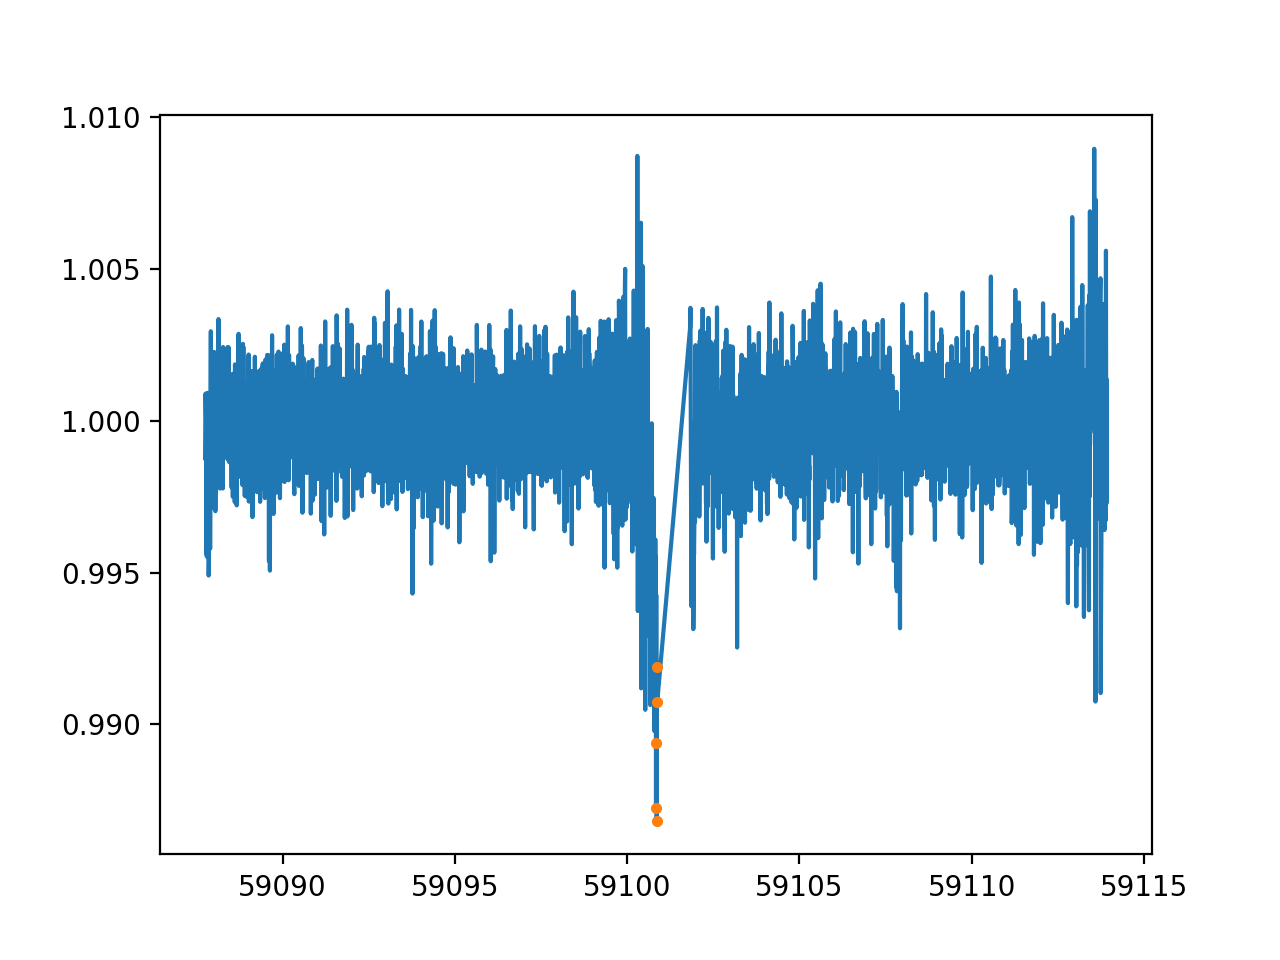

In [103]:
plt.figure()
plt.plot(lc[0],lc[1])
for s in segments:
    if len(s) > 2:
        plt.plot(lc[0,s],lc[1,s],'.')

In [91]:

likely = []

duration = []
depth = []
i = 0
for s in segments:
    if len(s) > 2:
        #try:
        y = lc[1,s[0]-4:s[-1]+5] - 1
        x = np.arange(s[0]-4,s[-1]+5)
        bds = ((0,s[0]-10,s[0]-10),(10,s[-1]+11,s[-1]+11))
        fit_params, pcov = curve_fit(parabola, x, y, bounds=bds)
        fit = parabola(x,*fit_params)
        ss_res = np.sum((y - fit) ** 2)
        # total sum of squares
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        # r-squared
        r2 = 1 - (ss_res / ss_tot)
        print(np.round(r2,2))
        if r2 >= 0.5:
            duration += [abs(lc[0,int(fit_params[2]+0.5)]-lc[0,int(fit_params[1]+0.5)])]
            l = lc[1,s]
            #plt.figure()
            #plt.plot(x,y)
            #plt.plot(x,parabola(x,*fit_params))
            #print(s)
            depth += [-np.min(parabola(x,*fit_params))]
        #except:
        #    pass
    i += 1
duration = np.array(duration)
depth = np.array(depth)
matched_depth = (abs((depth[:,np.newaxis] - depth[np.newaxis,:])) < 5*lcstd)
matched_duration = (abs((duration[:,np.newaxis] - duration[np.newaxis,:])) < 5/24)


if len(depth) > 1:
    std = np.std(depth)
    if (~matched_depth).any():
        if (matched_duration).all():
            likely = 'EB'
        else:
            likely = 'MP'
    else:
        likely = 'MT'
elif len(depth) == 0:
    likely = 'No'
    
else:
    likely = 'ST'

likely

0.6
0.97
0.5


'EB'

In [90]:
0.12*24

2.88

In [88]:
abs((duration[:,np.newaxis] - duration[np.newaxis,:]))

array([[0.        , 0.12499827, 0.02083568],
       [0.12499827, 0.        , 0.14583395],
       [0.02083568, 0.14583395, 0.        ]])

In [92]:
def vet_transit(lc):
    try:
        lc = np.array([lc['mjd'].values,lc['counts'].values])
    except:
        pass
    m, m, lcstd = sigma_clipped_stats(lc[1])
    lc_sig = (lc[1]-1)/lcstd

    siglim = -5
    sig_ind = np.where(lc_sig <= siglim)[0]
    segments = consecutive_points(sig_ind)
    duration = []
    depth = []
    i = 0
    for s in segments:
        if len(s) > 2:
            try:
                y = lc[1,s[0]-4:s[-1]+5] - 1
                x = np.arange(s[0]-4,s[-1]+5)
                bds = ((0,s[0]-10,s[0]-10),(10,s[-1]+11,s[-1]+11))
                fit_params, pcov = curve_fit(parabola, x, y, bounds=bds)
                fit = parabola(x,*fit_params)
                ss_res = np.sum((y - fit) ** 2)
                # total sum of squares
                ss_tot = np.sum((y - np.mean(y)) ** 2)
                # r-squared
                r2 = 1 - (ss_res / ss_tot)
                #print(np.round(r2,2))
                if r2 >= 0.5:
                    duration += [abs(lc[0,int(fit_params[2]+0.5)]-lc[0,int(fit_params[1]+0.5)])]
                    l = lc[1,s]
                    #plt.figure()
                    #plt.plot(x,y)
                    #plt.plot(x,parabola(x,*fit_params))
                    #print(s)
                    depth += [-np.min(parabola(x,*fit_params))]
            except:
                pass
        i += 1
    duration = np.array(duration)
    depth = np.array(depth)
    matched_depth = (abs((depth[:,np.newaxis] - depth[np.newaxis,:])) < 5*lcstd)
    matched_duration = (abs((duration[:,np.newaxis] - duration[np.newaxis,:])) < 5/24)


    if len(depth) > 1:
        std = np.std(depth)
        if (~matched_depth).any():
            if (matched_duration).all():
                likely = 'EB'
            else:
                likely = 'MP'
        else:
            likely = 'MT'
    elif len(depth) == 0:
        likely = 'No'

    else:
        likely = 'ST'

    return likely

In [93]:
likely = []
for file in files:
    lc = pd.read_csv(file)
    likely += [vet_transit(lc)]

In [94]:
exo = pd.read_csv('exo_test2/exo_test2_ref.csv')

In [95]:
exo['likely'] = likely

In [96]:
exo.to_csv('exo_test2_ref_likely.csv',index=False)

In [101]:
np.where(np.array(likely) == 'No')[0]

array([  4,  22,  29,  31,  33,  35,  40,  42,  59,  60,  64,  70,  79,
        80,  84,  89,  92, 104, 108, 111, 116, 120, 121, 124, 131, 140,
       141, 143, 148, 152, 156, 158, 160, 165, 167, 176, 177, 179, 195,
       196, 202, 203, 204, 212, 219, 221, 225, 226, 231, 236, 238, 239,
       240, 241, 255, 256, 260, 261, 270, 271, 272, 274, 279, 282, 283,
       286, 288, 290, 295, 297, 307, 309, 311, 315, 325, 335, 338, 350,
       359, 363, 366, 368, 374, 377, 399, 400, 401, 404, 406, 407, 408,
       412, 419, 426, 431, 432, 438, 441, 443, 445, 450, 465, 467, 475,
       480, 484, 490, 497, 498, 505, 507, 510, 512, 515, 520, 522, 535,
       543, 550, 554, 561, 562, 578, 579, 580, 583, 586, 588, 595, 596,
       599, 602, 604, 621, 626, 631, 635, 640, 645, 669, 673, 674, 676,
       682, 687, 688, 704, 705, 707, 711, 724, 725, 732, 737, 742, 749,
       750, 752, 763, 767, 771, 775, 787, 794, 797, 799, 800, 813, 819,
       829, 832, 840, 844, 849, 855, 857, 859, 869, 877, 878, 88

<IPython.core.display.Javascript object>


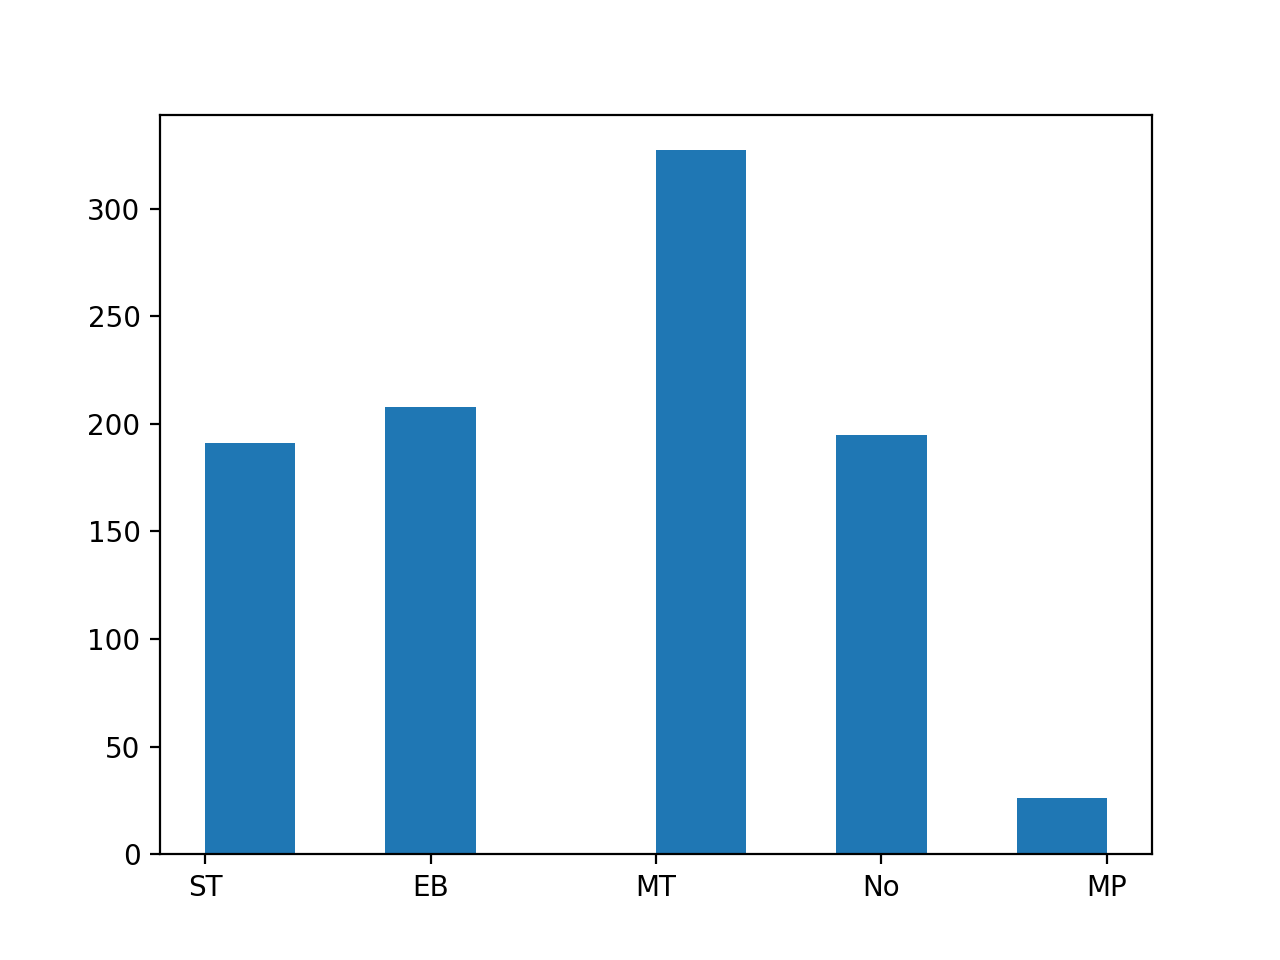

(array([191.,   0., 208.,   0.,   0., 327.,   0., 195.,   0.,  26.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

In [104]:
plt.figure()
plt.hist(likely)

In [528]:
vet_transit(lc)

'MT'

In [472]:
10*std

0.06974024134656104

In [473]:
abs((depth[:,np.newaxis] - depth[np.newaxis,:]))

array([[0.        , 0.00754626, 0.0010814 , 0.00731157, 0.01102298,
        0.00772912],
       [0.00754626, 0.        , 0.00862766, 0.01485784, 0.00347672,
        0.01527539],
       [0.0010814 , 0.00862766, 0.        , 0.00623018, 0.01210438,
        0.00664773],
       [0.00731157, 0.01485784, 0.00623018, 0.        , 0.01833456,
        0.00041755],
       [0.01102298, 0.00347672, 0.01210438, 0.01833456, 0.        ,
        0.01875211],
       [0.00772912, 0.01527539, 0.00664773, 0.00041755, 0.01875211,
        0.        ]])

In [474]:
matched_depth = (abs((depth[:,np.newaxis] - depth[np.newaxis,:])) < 5*std)
matched_duration = (abs((duration[:,np.newaxis] - duration[np.newaxis,:])))

In [483]:
(~matched_depth).any()

True

In [478]:
matched_duration < 1/24

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

In [479]:
duration

array([0.13889114, 0.1458353 , 0.15277924, 0.13194568, 0.13888979,
       0.13888921])

In [480]:
depth[:,np.newaxis] - depth[np.newaxis,:]

array([[ 0.        ,  0.00754626, -0.0010814 , -0.00731157,  0.01102298,
        -0.00772912],
       [-0.00754626,  0.        , -0.00862766, -0.01485784,  0.00347672,
        -0.01527539],
       [ 0.0010814 ,  0.00862766,  0.        , -0.00623018,  0.01210438,
        -0.00664773],
       [ 0.00731157,  0.01485784,  0.00623018,  0.        ,  0.01833456,
        -0.00041755],
       [-0.01102298, -0.00347672, -0.01210438, -0.01833456,  0.        ,
        -0.01875211],
       [ 0.00772912,  0.01527539,  0.00664773,  0.00041755,  0.01875211,
         0.        ]])

In [411]:
m = matched[1]


In [416]:
(m == matched).all(axis=1)

array([False, False, False, False, False, False])

In [ ]:
for i in range(len)

In [417]:
np.unique(matched,axis=1)

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [395]:
len(depth)

6

In [358]:
np.nanmedian(depth)

0.3519410758074065

In [315]:
j = 0
y = lc[1][segments[j][0]-4:segments[j][-1]+5]-1
x = np.arange(segments[j][0]-4,segments[j][-1]+5)
#bds = ((0,-1),(s[0]-10,s[-1]+10),(s[0]-10,s[-1]+10))
bds = ((-1,s[0]-5,s[0]-5),(10,s[-1]+5,s[-1]+5))
fit_params, pcov = curve_fit(parabola, x, y,bounds=bds)

<IPython.core.display.Javascript object>


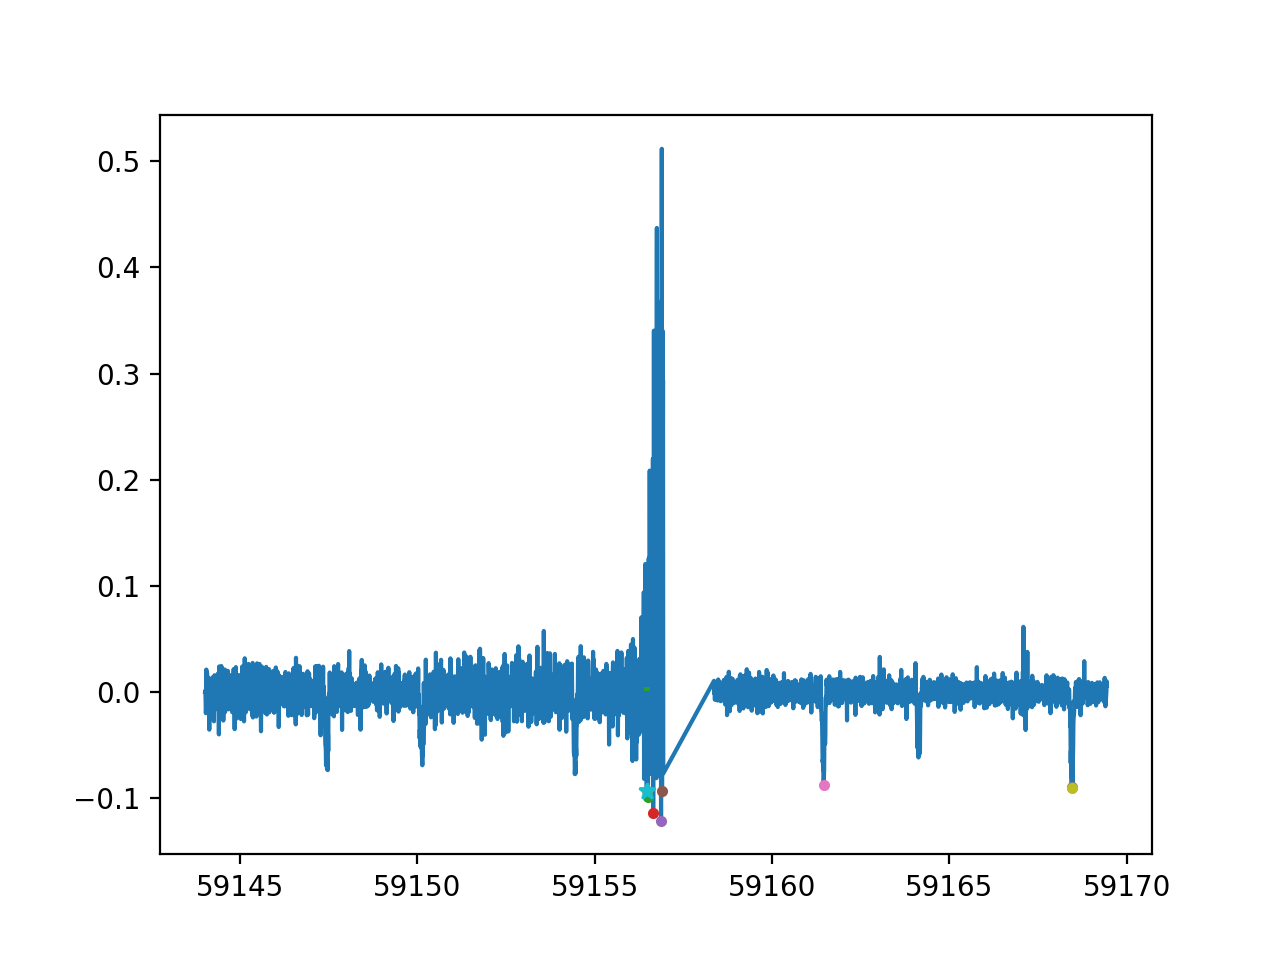

In [316]:

plt.figure()
plt.plot(lc[0],lc[1]-1)
for s in segments:
    plt.plot(lc[0,s],lc[1,s]-1,'.')
plt.plot(lc[0,segments[0]],lc[1,segments[0]]-1,'*')
    
plt.plot(lc[0,x],parabola(x,*fit_params),'C2')

In [293]:
depth

[0.16276016037721966, 0.03587360138598673, 0.02672316073193927]

In [70]:
np.diff(av_depth)

array([0.17364442])

In [73]:
np.std(length)

0.5

0.9520858389915507

In [43]:
plt.figure()
plt.plot()

[0.0345038577945701]

In [3]:
fit = pd.read_csv('preliminary_fits_of_good/fits.csv')

In [4]:
fit

,Unnamed: 0,filename,period_day,t0_mjd,dur_day,depth_fraction
0,0,Sec29_cam3_ccd1_cut10_object1513_norm_good,21.130343,59108.754478,0.25,0.169244
1,1,Sec29_cam3_ccd1_cut10_object1541_norm_good,17.037805,59090.889478,0.15,0.388529
2,2,Sec29_cam3_ccd1_cut10_object1818_norm_good,16.960067,59104.584478,0.25,0.304855
3,3,Sec29_cam3_ccd1_cut10_object2381_norm_good,4.196348,59088.884478,0.10,0.045650
4,4,Sec29_cam3_ccd1_cut11_object357_norm_good,12.882290,59088.219478,0.10,0.249698
...,...,...,...,...,...,...
703,703,Sec31_cam4_ccd4_cut8_object1069_norm_good,13.518458,59155.266845,0.20,0.206614
704,704,Sec31_cam4_ccd4_cut8_object796_norm_good,12.312542,59150.321845,0.15,0.370369
705,705,Sec31_cam4_ccd4_cut8_object959_norm_good,15.617372,59153.231845,0.15,0.058666
706,706,Sec31_cam4_ccd4_cut9_object374_norm_good,11.847593,59145.846845,0.10,0.303819
